# Indentification of Adjusting Coefficients 

We will use a gradient discent algorithm for identifing the parameters 

In [1]:
import numpy as np
import matplotlib as plt
import os 
import timeit
import jax.numpy as jnp
from jax import grad, jit

### Import the data

In [2]:
# Standard library imports
import sys
# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
data_processor_I = preprocessing(CONFIGURATION_I)

# Extract test data 
X_train, y_train = data_processor_I.X_train, data_processor_I.y_train

### Define the functions 

In [3]:
def compute_stiffness(w, th , E , l1 , l2 , oe): 
    """
    Inputs:
    w - Beam width
    th - Beam thickness 
    E - Young's modulus of the beam material
    l1 - Length of the longer beams
    l2 - Length of the shorter beams
    oe - Overetch affecting the effective width of the beam

     Output:
     kTotal - Total stiffness of the folded beam structure
    """
    effectiveWidth = w - 2*oe
    J = (1/12) * th * effectiveWidth**3
    #Stiffness of individual beams based on their length
    k1 = 12 * E * J / (l1**3 * 4)
    k2 = 12 * E * J / (l2**3 * 2)
    kTotal = 2 / (1/k1 + 1/k2)
    
    return kTotal


In [4]:
def fringing_coeff( G, W ,L):
    return (1+ G/np.pi/W + G/np.pi/W*np.log(2*np.pi*W/G))*(1+ G/np.pi/L + G/np.pi/L*np.log(2*np.pi*L/G))

In [5]:
def coarse_model(params, w0, w1, w2):
    """
    - Inputs:
    - parameters[0] : Overetch 
    - parameters[1] : Offset
    - parameters[2] : Thickness

    - Output:
    - C : An array containing the computed difference of capacitance 
    """
    # Time parameters
    t0 = 0                    # Initial time.
    tf = 0.0015-1e-5          # Final time.
    dt =1e-5                  # Time step size.

    # Stiffness parameters
    l1 = 221.4*1e-6              # Lenght of the longer beam 
    l2 = 110*1e-6            # Length of the shorted beam
    E  = 160*1e9               # Young Modulus 
    w  = 2.8*1e-6              # Width 

    # Force parameters 
    phi = lambda t: 0.9*(1-np.cos(2*np.pi*2500*t)) if t < 2/2500 else 0 # Voltage in the right electrodes
    s   = 101*1e-6             # param for the surface 
    dp  =1.2*1e-6                # Distance from the plates with Overetch and Offset = 0 

    # Mass parameters
    rho = 2320                 # Density of the mass.
    A   = 84*1e-9              # Area of the component

    # Damping parameters 
    alpha = 31440            # Damping coefficient alpha. 31400
    beta  =  0               # Damping coeff beta 

    # Input Parameters 
    oe = params[0]*1e-6
    of = params[1]*1e-6
    th = params[2]*1e-6 # ricorda di rimettere 6
   
    eps0 = 8.854*1e-12       # Dielectric permittivity constant
    eps1 = 1.000             # Relative dielectric permittivity of air.

    # Compute the distance between the faces of electrodes and the sensor
    dl = dp+2*oe+of
    dr = dp+2*oe-of
    # Compute the surface of the electrode 
    S = th * (s - 2*oe) * 10  # multiply by ten since we have 10 condensators
    
    # Initial conditions
    u0 = 0  # Initial displacement
    v0 = 0  # Initial velocity
    N = int((tf - t0) / dt)

    # Initialization
    u = np.zeros((N+1))  # displacement
    v = np.zeros((N+1))  # velocity
    C = np.zeros((N+1))  # capacitance
    u[0] = u0
    v[0] = v0
    C[0] = eps1*eps0*S*(1/(dr)*fringing_coeff( dr, s-2*oe ,th) - 1/(dl)*fringing_coeff( dl, s-2*oe ,th))

    # Compute the stiffness
    k = compute_stiffness(w, th , E , l1 , l2 , oe) 
   
    # Compute mass
    m = rho * A * th
    # Compute Damping 
    damp = alpha* m + beta* k

    # Precompute phi values to avoid redundant computation
    k1 =  0.5 * eps0 * eps1 * S
    k2 = eps1*eps0*S
    F_values = np.array([phi(n * dt) for n in range(N)])**2 * k1

    # Time-stepping loop using Forward Euler scheme
    for n in range(N) :
        u_n = u[n]
        v_n = v[n]
        u_new = u_n + dt * v_n
        # Compute the value of the input voltage at time t = n*dt 
        F = F_values[n]/((dr-u_n)**2)
        v[n+1] = v_n + dt * ( F - damp*v_n - k*u_n )/m
        # Compute the difference of capacitance
        C[n+1] = k2*(1/(dr-u_new)*fringing_coeff( dr-u_new, s-2*oe ,th) - 1/(dl+u_new)*fringing_coeff( dl+u_new, s-2*oe ,th))
        u[n+1] = u_new
    
    # Adjusting phase 
    C = C*1.02*1e15 + w0*params[0] + w1*params[1] + w2*params[2]

    return C

### Optimize the parameters 

In [119]:
import numpy as np

def loss_function(y_pred, y_true):
    # Mean squared error loss
    return np.mean((y_pred - y_true) ** 2)

def gradient_descent(X_train, y_train, w0, w1, w2, learning_rate=1e-3, num_iterations=150, batch_size=640 ):
    num_samples = len(X_train)
    for _ in range(num_iterations):
        # Sample random indices for mini-batch
        #batch_indices = np.random.choice(num_samples, size=batch_size, replace=False)
        X_batch = X_train#[batch_indices]
        y_batch = y_train#[batch_indices]

        # Compute predictions
        y_pred = np.array([coarse_model(X_batch[j, :], w0, w1, w2) for j in range(len(X_batch))])
        
        # Compute loss
        loss = loss_function(y_pred, y_batch)
        
        # Compute gradients
        grad_w0 = np.mean(2 * (y_pred - y_batch) * X_batch[:, 0, np.newaxis], axis=0)
        grad_w1 = np.mean(2 * (y_pred - y_batch) * X_batch[:, 1, np.newaxis], axis=0)
        grad_w2 = np.mean(2 * (y_pred - y_batch) * X_batch[:, 2, np.newaxis], axis=0)
        
        # Update parameters with adaptive learning rate
        current_learning_rate = np.max( (learning_rate / (0.05*_ + 1), 1e-8) ) 
        w0 -= current_learning_rate * grad_w0
        w1 -= current_learning_rate * grad_w1
        w2 -= current_learning_rate * grad_w2
        
        # Print loss and learning rate for monitoring
        print("Iteration {}, Loss: {}, Learning Rate: {}".format(_, loss, current_learning_rate))
        
    return w0, w1, w2

# Assuming X_train and y_train are already defined
# Initialize parameters
w0 = np.zeros(150)
w1 = np.zeros(150)
w2 = np.zeros(150)

# Run gradient descent
w0_optimized, w1_optimized, w2_optimized = gradient_descent( X_train, y_train, w0, w1, w2 )

Iteration 0, Loss: 0.1630437493658408, Learning Rate: 0.001
Iteration 1, Loss: 0.13255918573187087, Learning Rate: 0.0009523809523809524
Iteration 2, Loss: 0.10597165240906224, Learning Rate: 0.0009090909090909091
Iteration 3, Loss: 0.08946661132136795, Learning Rate: 0.0008695652173913044
Iteration 4, Loss: 0.08180833876420239, Learning Rate: 0.0008333333333333334
Iteration 5, Loss: 0.07910337075485997, Learning Rate: 0.0008
Iteration 6, Loss: 0.07836971113602142, Learning Rate: 0.0007692307692307692
Iteration 7, Loss: 0.07821355523134263, Learning Rate: 0.0007407407407407407
Iteration 8, Loss: 0.0781834045039974, Learning Rate: 0.0007142857142857144
Iteration 9, Loss: 0.07817385380530484, Learning Rate: 0.0006896551724137932
Iteration 10, Loss: 0.07816696418626094, Learning Rate: 0.0006666666666666666
Iteration 11, Loss: 0.07816050653739212, Learning Rate: 0.0006451612903225806
Iteration 12, Loss: 0.07815427055756753, Learning Rate: 0.000625
Iteration 13, Loss: 0.07814823101143917, L

In [86]:
save = True 

if save: 
    np.savetxt('./models/w0_opt.txt', w0_optimized)
    np.savetxt('./models/w1_opt.txt', w1_optimized)
    np.savetxt('./models/w2_opt.txt', w2_optimized)

# See the results 

### Let us now see how our adjusted model behaves 

In [59]:
saved = False

if saved:  
    w0 = np.loadtxt('./models/w0_opt.txt')
    w1 = np.loadtxt('./models/w1_opt.txt')
    w2 = np.loadtxt('./models/w2_opt.txt')
else :  
    w0 = w0_optimized
    w1 = w1_optimized
    w2 = w2_optimized

In [74]:
# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

# Which sample of the training set do wou want to take as experimental input?
sample = [5,11, 22, 38, 154] # [5,16, 17, 71, 159]
sample  = np.random.choice(len(X_values), size=5, replace=False)

# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
print('        Overetch,   Offset,   Thickness')
x_true

        Overetch,   Offset,   Thickness


array([[ 0.357769,  0.290536, 30.944346],
       [ 0.291355, -0.08473 , 29.157343],
       [ 0.332729,  0.186492, 29.042718],
       [ 0.251434, -0.449111, 29.131398],
       [ 0.381797,  0.116394, 29.238688]])

The parameters used are: [ 0.357769  0.290536 30.944346]


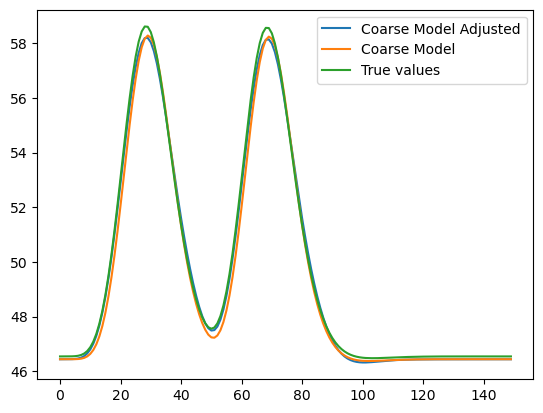

The parameters used are: [ 0.291355 -0.08473  29.157343]


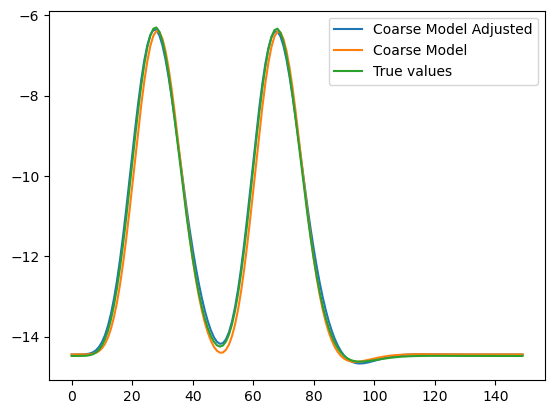

The parameters used are: [ 0.332729  0.186492 29.042718]


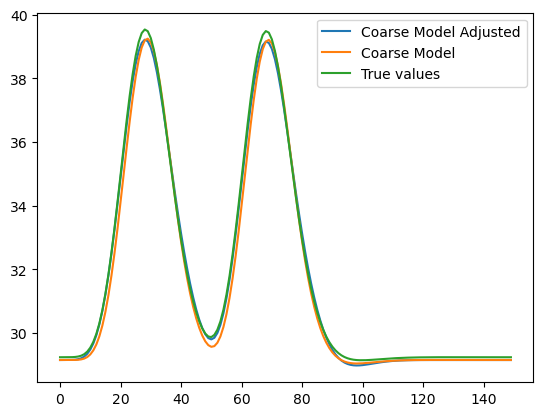

The parameters used are: [ 0.251434 -0.449111 29.131398]


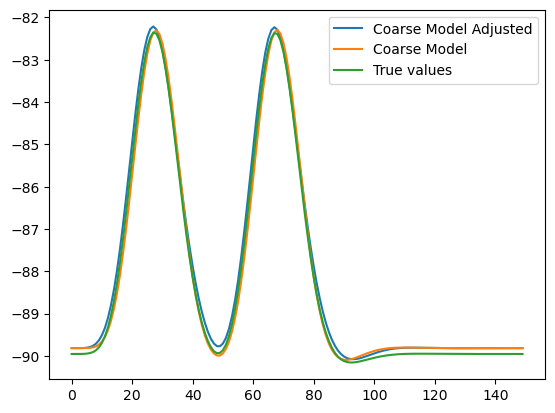

The parameters used are: [ 0.381797  0.116394 29.238688]


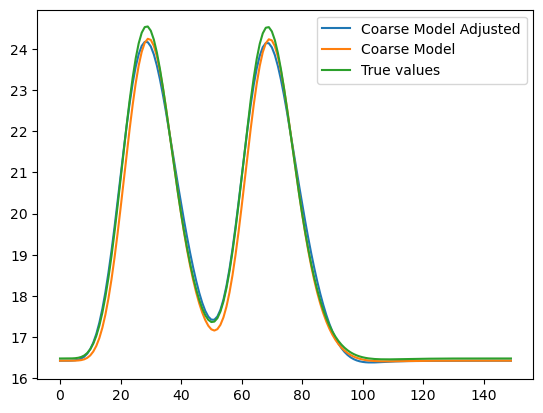

Mean absolute percentage errors for the adjusted model are:
 [0.00325174 0.00667726 0.00387432 0.00194073 0.00618678]

Mean absolute percentage errors for the simulations are:
 [0.00538692 0.01098306 0.00729013 0.00172353 0.00934484]


In [120]:
ratio_adj = []
ratio = []

points = np.linspace(0,0.0015-1e-5,150)
phi = lambda t: np.abs(np.cos(2*np.pi*2500*t)) if t < 2.25/2500 and t > 0.25/2500 else 0
coeff = [phi(t) for t in points]

for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    res_adj = coarse_model(x,w0,w1,w2) 
    res = coarse_model(x,np.zeros(150),np.zeros(150),np.zeros(150))

    plt.plot(res_adj)
    plt.plot(res)
    plt.plot(y_true[index])
    plt.legend(['Coarse Model Adjusted', 'Coarse Model', 'True values'])
    plt.show()
    ratio.append(  np.linalg.norm((res - y_true[index]), ord=1)  / np.linalg.norm(( y_true[index]), ord=1) )
    ratio_adj.append(  np.linalg.norm((res_adj - y_true[index]), ord=1)  / np.linalg.norm(( y_true[index]), ord=1) )
#plt.plot(y_true[-1]-res)
#plt.show()
print('Mean absolute percentage errors for the adjusted model are:\n', np.array(ratio_adj) ) 
print('\nMean absolute percentage errors for the simulations are:\n', np.array(ratio) ) 

Compute the mean absolute percentage on the whole test set 

In [85]:
ratio_adj = []
ratio = []
for index, x in enumerate(X_values):
    res_adj = coarse_model(x,w0,w1,w2) 
    res = coarse_model(x,np.zeros(150),np.zeros(150),np.zeros(150))
    ratio.append(  np.linalg.norm((res - y_values[index]), ord=1)  / np.linalg.norm(( y_values[index]), ord=1) )
    ratio_adj.append(  np.linalg.norm((res_adj - y_values[index]), ord=1)  / np.linalg.norm(( y_values[index]), ord=1) )

print('ADJUSTED COARSE MODEL')
print('Mean absolute percentage errors is:\n', np.mean(np.array(ratio_adj) )) 
print('The maximum and minimun MAPE are \n', np.max(np.array(ratio_adj)), np.min(np.array(ratio_adj)))

print('\n\nCOARSE MODEL')
print('Mean absolute percentage errors is:\n', np.mean(np.array(ratio)) ) 
print('The maximum and minimun MAPE are \n', np.max(np.array(ratio)), np.min(np.array(ratio)))

ADJUSTED COARSE MODEL
Mean absolute percentage errors is:
 0.006538226878432807
The maximum and minimun MAPE are 
 0.07250870519795931 0.000827771717693568


COARSE MODEL
Mean absolute percentage errors is:
 0.00917129672553629
The maximum and minimun MAPE are 
 0.0652993713411578 0.0015532821626572325
